In [26]:
import os
os.getcwd()


'/Users/shashwatshrivastava/CrediRisk-Analyser'

In [28]:
import zipfile

zip_path = "/Users/shashwatshrivastava/home-credit-default-risk.zip"
extract_to = "/Users/shashwatshrivastava/home_credit_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [30]:
import pandas as pd
import sqlite3

base_path = "/Users/shashwatshrivastava/home_credit_data"
conn = sqlite3.connect(":memory:")

# Primary Table
app = pd.read_csv(f"{base_path}/application_train.csv")
app.to_sql("application", conn, index=False)

# Secondary Tables
tables = {
    "bureau": "bureau.csv",
    "bureau_balance": "bureau_balance.csv",
    "previous_application": "previous_application.csv",
    "installments_payments": "installments_payments.csv",
    "credit_card_balance": "credit_card_balance.csv",
    "POS_CASH_balance": "POS_CASH_balance.csv"
}

for name, file in tables.items():
    df = pd.read_csv(f"{base_path}/{file}")
    df.to_sql(name, conn, index=False)


In [32]:
conn.execute("""
CREATE VIEW bureau_agg AS
SELECT
  b.SK_ID_CURR,
  COUNT(*) AS bureau_count,
  AVG(b.AMT_CREDIT_SUM) AS bureau_credit_avg,
  MAX(bb.MONTHS_BALANCE) AS bureau_last_month
FROM bureau b
LEFT JOIN bureau_balance bb ON b.SK_ID_BUREAU = bb.SK_ID_BUREAU
GROUP BY b.SK_ID_CURR
""")


In [34]:
conn.execute("""
CREATE VIEW prev_app_agg AS
SELECT
  SK_ID_CURR,
  COUNT(*) AS prev_app_count,
  AVG(AMT_APPLICATION) AS prev_app_avg_amt,
  MAX(DAYS_DECISION) AS last_app_days
FROM previous_application
GROUP BY SK_ID_CURR
""")


In [35]:
conn.execute("""CREATE VIEW inst_agg AS
SELECT
  SK_ID_CURR,
  AVG(AMT_PAYMENT / AMT_INSTALMENT) AS pay_to_instal_ratio_avg,
  COUNT(*) AS inst_count
FROM installments_payments
WHERE AMT_INSTALMENT > 0
GROUP BY SK_ID_CURR;

""")

In [36]:
conn.execute("""CREATE VIEW cc_agg AS
SELECT
  SK_ID_CURR,
  MAX(MONTHS_BALANCE) AS cc_last_month,
  AVG(AMT_BALANCE) AS cc_avg_balance
FROM credit_card_balance
GROUP BY SK_ID_CURR;
""")


In [37]:
conn.execute("""CREATE VIEW pos_agg AS
SELECT
  SK_ID_CURR,
  COUNT(*) AS pos_count,
  MIN(MONTHS_BALANCE) AS pos_first_use
FROM POS_CASH_balance
GROUP BY SK_ID_CURR;
""")

In [38]:
final_query = """
SELECT
  a.*,
  ba.bureau_count,
  ba.bureau_credit_avg,
  ba.bureau_last_month,
  pa.prev_app_count,
  pa.prev_app_avg_amt,
  pa.last_app_days,
  ia.pay_to_instal_ratio_avg,
  ia.inst_count,
  cca.cc_last_month,
  cca.cc_avg_balance,
  psa.pos_count,
  psa.pos_first_use
FROM application a
LEFT JOIN bureau_agg ba ON a.SK_ID_CURR = ba.SK_ID_CURR
LEFT JOIN prev_app_agg pa ON a.SK_ID_CURR = pa.SK_ID_CURR
LEFT JOIN inst_agg ia ON a.SK_ID_CURR = ia.SK_ID_CURR
LEFT JOIN cc_agg cca ON a.SK_ID_CURR = cca.SK_ID_CURR
LEFT JOIN pos_agg psa ON a.SK_ID_CURR = psa.SK_ID_CURR
"""


In [39]:
merged_df = pd.read_sql_query(final_query, conn) 
merged_df.to_csv("final_merged.csv", index=False)


merged_df.head

In [41]:
merged_df.head

<bound method NDFrame.head of         SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0          

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

merged_df = merged_df[merged_df['TARGET'].notnull()]

X = merged_df.drop(columns=['SK_ID_CURR', 'TARGET'])
y = merged_df['TARGET']

X = pd.get_dummies(X, drop_first=True)

X = X.fillna(X.median(numeric_only=True))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [45]:

cat_cols = X.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:\n", cat_cols.tolist())


Categorical columns:
 []


In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pickle


merged_df = pd.read_csv("final_merged.csv")
merged_df = merged_df[merged_df['TARGET'].notnull()]  # Drop missing targets


X = merged_df.drop(columns=['SK_ID_CURR', 'TARGET'])
y = merged_df['TARGET']


cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


X = X.fillna(X.median(numeric_only=True))


with open("model_columns.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# Save model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:07:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.58      0.03      0.05      4949

    accuracy                           0.92     61503
   macro avg       0.75      0.51      0.50     61503
weighted avg       0.89      0.92      0.89     61503



In [49]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


In [51]:

from sklearn.metrics import roc_auc_score
y_probs = model.predict_proba(X_test)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

ROC-AUC Score: 0.7650441262557187
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.58      0.03      0.05      4949

    accuracy                           0.92     61503
   macro avg       0.75      0.51      0.50     61503
weighted avg       0.89      0.92      0.89     61503



In [52]:
from sklearn.metrics import roc_auc_score
y_probs = model.predict_proba(X_test)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))


ROC-AUC Score: 0.7650441262557187


Classification report at threshold = 0.2
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     56554
           1       0.29      0.30      0.29      4949

    accuracy                           0.89     61503
   macro avg       0.61      0.62      0.62     61503
weighted avg       0.89      0.89      0.89     61503



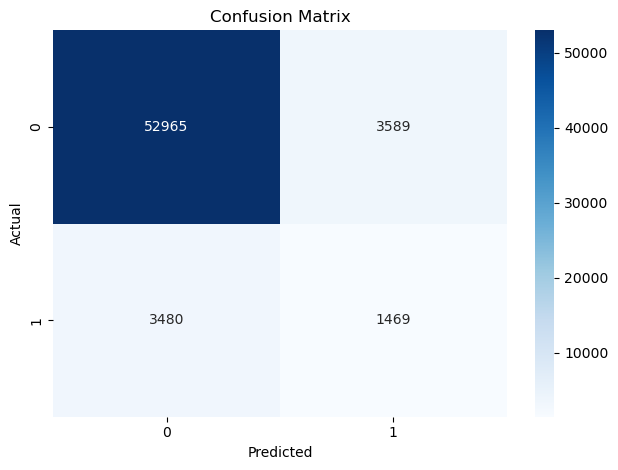

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

y_probs = model.predict_proba(X_test)[:, 1] 


threshold = 0.2
y_pred_thresh = (y_probs > threshold).astype(int)


print(f"Classification report at threshold = {threshold}")
print(classification_report(y_test, y_pred_thresh))


import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(y_test, y_pred_thresh), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [56]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(model)


X_sample = X_test[:200]


shap_values = explainer.shap_values(X_sample)


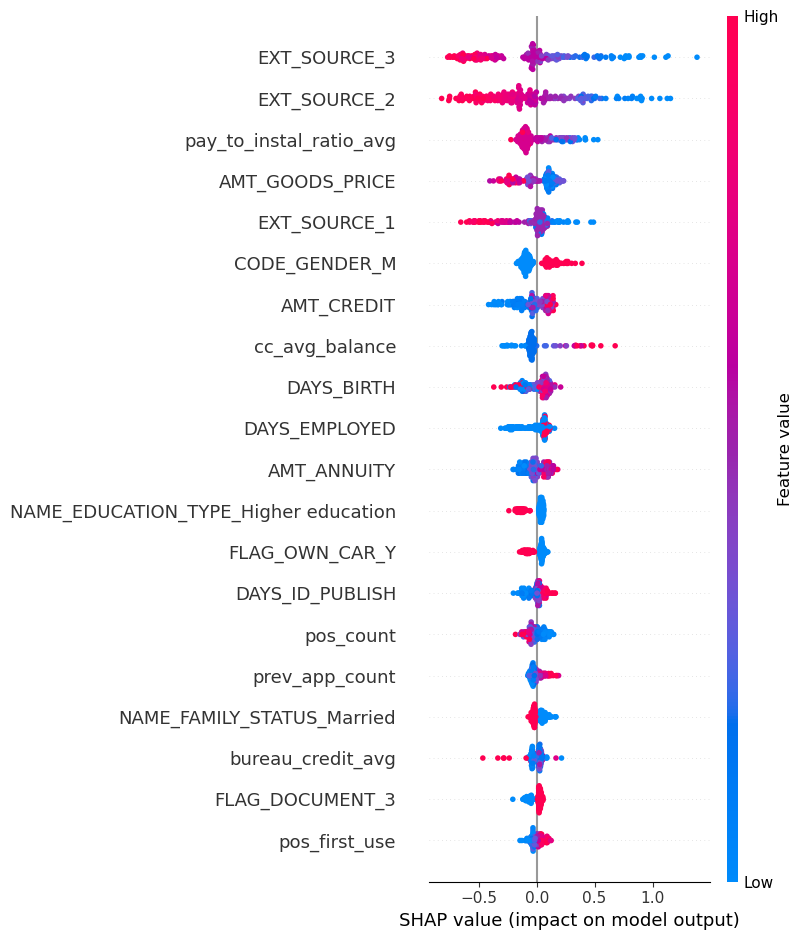

In [57]:
# Summary plot
shap.summary_plot(shap_values, X_sample, feature_names=X.columns)


In [58]:
import pickle


with open("model.pkl", "wb") as f:
    pickle.dump(model, f)


In [59]:
import streamlit as st
import pandas as pd
import shap
import pickle
from streamlit_shap import st_shap  # pip install streamlit-shap

# Load model and expected columns
model = pickle.load(open("model.pkl", "rb"))
model_columns = pickle.load(open("model_columns.pkl", "rb"))

# Load data
data = pd.read_csv("final_merged.csv")
X = data.drop(columns=["TARGET"])
y = data["TARGET"]

# Encode categorical columns
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Align columns with model expectations
X_encoded = X_encoded.reindex(columns=model_columns, fill_value=0)

# Sidebar input
st.sidebar.title("Customer Risk Profiling")
selected_idx = st.sidebar.slider("Select Customer Index", 0, len(X_encoded) - 1, 0)
customer = X_encoded.iloc[[selected_idx]]

# Risk Prediction
prob = model.predict_proba(customer)[0][1]
st.write(f"### Risk Score for Customer {selected_idx}: {prob:.2f}")

# SHAP Explanation
st.write("### SHAP Explanation")
explainer = shap.Explainer(model)
shap_values = explainer(customer)

# Force plot (interactive SHAP)
st_shap(shap.plots.force(shap_values[0]), height=300)


DeltaGenerator()

In [60]:
!jupyter nbconvert --to script Untitled.ipynb




[NbConvertApp] Converting notebook Untitled.ipynb to script
[NbConvertApp] Writing 8334 bytes to Untitled.py
